### Task 1: 

In [2]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy


In [3]:

plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    #use GPU acceleration
    device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape, device = device) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])



In [4]:

def run_model(model, params ,n_epochs = 100):
    print(len(params))
    train_loss = []
    test_loss = []

    optimizer = RMSprop(params=params)


    #define device
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Device:', device)
    torch.cuda.set_device(device)

    # put this into a training loop over 100 epochs
    for epoch in range(n_epochs + 1):
        train_loss_this_epoch = []
        for idx, batch in enumerate(train_dataloader):
            x, y = batch
            x, y = x.to(device), y.to(device)

            # our model requires flattened input
            x = x.reshape(batch_size, 784)
            # feed input through model
            #noise_py_x = model(x, w_h, w_h2, w_o)
            noise_py_x = model(x, *params)
            # reset the gradient
            optimizer.zero_grad()

            # the cross-entropy loss function already contains the softmax
            loss = cross_entropy(noise_py_x, y, reduction="mean")
            train_loss_this_epoch.append(float(loss.to("cpu")))

            # compute the gradient
            loss.backward()
            # update weights
            optimizer.step()


        train_loss.append(np.mean(train_loss_this_epoch))

        # test periodically
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}")
            print(f"Mean Train Loss: {train_loss[-1]:.2e}")
            test_loss_this_epoch = []

            # no need to compute gradients for validation
            with torch.no_grad():
                for idx, batch in enumerate(test_dataloader):
                    x, y = batch
                    x, y = x.to(device), y.to(device)
                    x = x.reshape(batch_size, 784)
                    noise_py_x = model(x, *params)

                    loss = cross_entropy(noise_py_x, y, reduction="mean")
                    test_loss_this_epoch.append(float(loss.cpu()))

            test_loss.append(np.mean(test_loss_this_epoch))

            print(f"Mean Test Loss:  {test_loss[-1]:.2e}")
    return train_loss, test_loss


def plot_results(train_loss, test_loss, n_epochs, label_addition = ""):
    plt.plot(np.arange(n_epochs + 1), train_loss, label=f"{label_addition}_Train")
    plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label=f"{label_addition}_Test")
    plt.title("Train and Test Loss over Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


## model from intro

3
Device: cuda:0
Epoch: 0
Mean Train Loss: 3.95e-01
Mean Test Loss:  1.69e-01
Epoch: 10
Mean Train Loss: 1.57e-01
Mean Test Loss:  2.36e-01
Epoch: 20
Mean Train Loss: 9.68e-02
Mean Test Loss:  3.37e-01
Epoch: 30
Mean Train Loss: 6.37e-02
Mean Test Loss:  4.73e-01
Epoch: 40
Mean Train Loss: 5.50e-02
Mean Test Loss:  6.74e-01
Epoch: 50
Mean Train Loss: 3.37e-02
Mean Test Loss:  7.58e-01
Epoch: 60
Mean Train Loss: 2.76e-02
Mean Test Loss:  8.20e-01
Epoch: 70
Mean Train Loss: 2.71e-02
Mean Test Loss:  6.54e-01
Epoch: 80
Mean Train Loss: 1.61e-02
Mean Test Loss:  9.31e-01
Epoch: 90
Mean Train Loss: 9.79e-03
Mean Test Loss:  8.42e-01
Epoch: 100
Mean Train Loss: 8.77e-03
Mean Test Loss:  1.04e+00


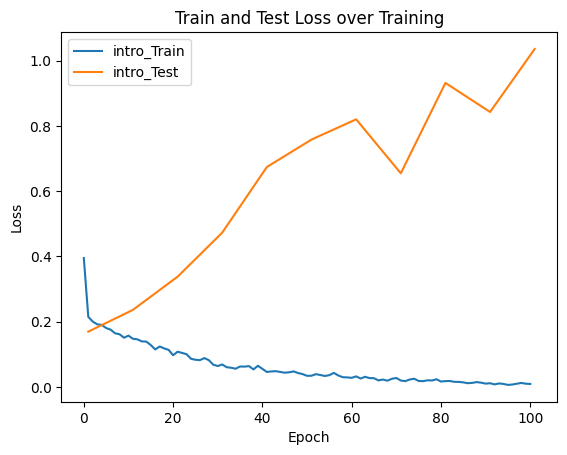

In [22]:
#epochs to train
n_epochs = 100

# define the neural network
def intro_model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
intro_params = [w_h, w_h2, w_o]

intro_train_loss, intro_test_loss = run_model(intro_model, intro_params, n_epochs)

plot_results(intro_train_loss,intro_test_loss, n_epochs, "intro")

### Task 2: Drop-out layer

In [23]:

#define dropout layer
def dropout(X , p_drop = 0.5) :

    #check device in case of GPU 
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    #return unchanged X
    if p_drop <= 0.0 or p_drop >= 1.0:
        return X

    #create mask from dropout threshold using numbers generated by binomial distribution
    mask = torch.bernoulli(torch.ones(X.size()) * p_drop).type(torch.bool).to(device)

    #now set 0 if mask value is 1 else set it to xi/(1-p_drop)
    return torch.where(mask, 0, X/(1-p_drop))


def dropout_model(x , w_h , w_h2 , w_o , p_drop_input = 0.1 , p_drop_hidden = 0.1):

    #apply dropout to X
    x_drop = dropout(x, p_drop = p_drop_input)
    h = rectify(x_drop @ w_h)

    #apply dropout to h
    h_drop = dropout(h, p_drop = p_drop_hidden)
    h2 = rectify(h_drop @ w_h2)

    #apply dropout to h2
    h2_drop = dropout(h2, p_drop = p_drop_hidden)
    pre_softmax = h2_drop @ w_o

    return pre_softmax


3
Device: cuda:0
Epoch: 0
Mean Train Loss: 4.51e-01
Mean Test Loss:  3.01e-01
Epoch: 10
Mean Train Loss: 2.42e-01
Mean Test Loss:  2.83e-01
Epoch: 20
Mean Train Loss: 2.11e-01
Mean Test Loss:  3.53e-01
Epoch: 30
Mean Train Loss: 2.21e-01
Mean Test Loss:  6.19e-01
Epoch: 40
Mean Train Loss: 2.13e-01
Mean Test Loss:  8.28e-01
Epoch: 50
Mean Train Loss: 1.99e-01
Mean Test Loss:  7.59e-01
Epoch: 60
Mean Train Loss: 1.98e-01
Mean Test Loss:  8.17e-01
Epoch: 70
Mean Train Loss: 1.70e-01
Mean Test Loss:  9.56e-01
Epoch: 80
Mean Train Loss: 1.85e-01
Mean Test Loss:  8.50e-01
Epoch: 90
Mean Train Loss: 1.70e-01
Mean Test Loss:  9.54e-01
Epoch: 100
Mean Train Loss: 1.62e-01
Mean Test Loss:  7.90e-01


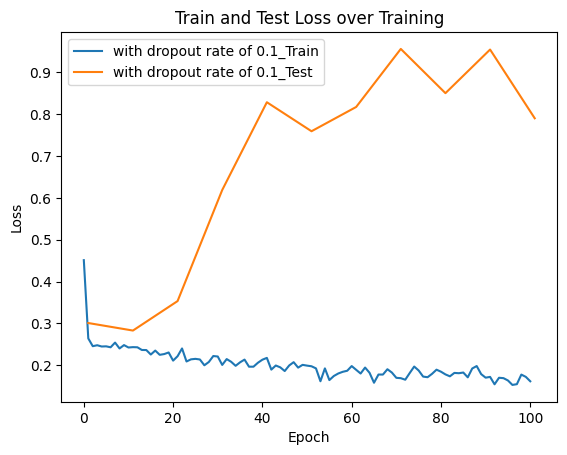

In [24]:
#train model and show data

#epochs to train
n_epochs = 100

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
intro_params = [w_h, w_h2, w_o]

intro_train_loss, intro_test_loss = run_model(dropout_model, intro_params, n_epochs)

plot_results(intro_train_loss,intro_test_loss, n_epochs, "with dropout rate of 0.1")

* Dropout method is used as a regularization technique to reduce overfitting during training. During training of neural network, a proporation of input neurons are set to 0 based on given prior probability or `dropout_rate`. We are setting those values to zero thus the work dropping out. It penalizes the model to rely on few neurons for predictions and thus improving connectivity of neurons across all neurons to generalize.

* By randomly dropping out units, dropout introduces unpredictable noise and prevents strong biased connections between few neurons. This noise forces the neural network to learn redundant features, making it more robust to variations in the input data. Concequenty, dropout helps reduce overfitting by preventing the model from memorizing the training data too closely and improves the model's ability to generalize to unseen data.

* In test environment, we aim to get reproducible and reliable predictions. However, dropout introduces noise which in turn generates randomness during testing. Therefore a new test configuration is required for testing on unseen data. It includes either removing dropout layers or disabling them and sometimes use of modified network with adjusted layers for absence of dropout. By evaluating the model after dropout layers removal, we can obtain a more reliable and reproducible estimate of its generalization performance on new, unseen data. 

* The difference between training and testing error with dropout enabled network is significantly lower than in the case of normal model.
* The test errors for normal model vs dropout model are very similar and comparable when used for values in 0.1-0.2 range (with slight improvements with 0.1 or lower value), however, too large value can cause dropout model to perform worse as found in our experiments.


### Task 3: PReLU

In [ ]:

def prelu(x,a):
    zero = torch.zeros_like(x)
    return torch.max(zero,x) + torch.min(zero,x)*a

def prelu_model(x, w_h, w_h2, w_o, a):
    h = prelu(x @ w_h, a)

    h2 = prelu(h @ w_h2, a)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
a = init_weights((100,625))

#optimizer = RMSprop(params=[w_h, w_h2, w_o])


params = [w_h, w_h2, w_o, a]

prelu_train_loss, prelu_test_loss = run_model(prelu_model, params, n_epochs)

plot_results(prelu_train_loss,prelu_test_loss,n_epochs,"prelu")

In [ ]:
print(prelu_train_loss)

[0.43111410001292827, 0.21865547606255858, 0.18132685039852126, 0.16782314110430888]
